---
# <div align="center"><font color='pink'> COSC 2673/2793 | Machine Learning</font></div>
## <div align="center"> <font size=50 color='pink'>Classify Images of Cancer</font></div>
---

# Acknowledgments:

Thank the Machine Learning course Sem 1 2023 instructors at RMIT University for providing me with valuable knowledge, guidance, and support throughout this report. The course lectures, slides, code examples, and tutorials have been instrumental in developing my understanding of various machine-learning concepts and techniques. 

# Introduction

The dataset description contains 27x27 RGB images of cells from 99 different patients. The images are histopathology images that show cells at the microscopic level. The goal is to classify these cells based on whether they are cancerous and also to classify them according to their cell type.



<a id="0"></a>
# TABLE OF CONTENTS

<br>

### 1. [Import](#1)


<br>
<br>


### 2. [Data Overview](#2)

<br>
<br>

### 3. [Data Exploratory Analysis](#3)

<br>
<br>

### 4. [Data Preprocessing](#3)
+ Preprocess the images and their labels according to the provided CSV files (mainData.csv and extraData.csv).
+ Perform data augmentation if necessary.


<br>
<br>

### 4. [Train Test Split](#4)

<br>
<br>

<br>
<br>

### 6. [Evaluation Framework](#6)


Use appropriate evaluation metrics considering class imbalance, such as precision, recall, F1-score, or the area under the Receiver Operating Characteristic (ROC) curve.
Perform analysis and comparison between classifying the two categories.


<br>
<br>

### 7. [Baseline model - Convolutional neural networks (CNN) from Scratch](#7)

<br>
<br>

### 8. [Extended Models - Part 1](#8)

+ Perform hyperparameter tuning to refine the models.
+ Consider using class weights during model training to account for the imbalance in the dataset.

8.3 [Best Model](#8.3)

<br>
<br>

### 9. [Extra Model - Part 2 - (Deep learning)](#9)

<br>
<br>


### 10. [Further Data Preprocessing](#10)


<br>
<br>

### 11. [Extended Model - Part 3 (Use Data after Preprocessing)](#11)

<br>
<br>

### 11. [Ultimate judgment](#11)
Determine the criteria by which we evaluate your models and decide what it means to be "the best model."
Make an ultimate judgment of the best model for each task, considering performance metrics and other factors such as interpretability, robustness, and computational efficiency.

<br>
<br>

### 11. [Independent evaluation](#11)
Research published works using the same or similar datasets.
Compare and contrast our results with those works.

<br>
<br>

### 12. [Discussion](#12)

<br>
<br>

### 13. [Summary](#13)

<br>
<br>

### 14. [Extra References](#14)

<hr>


<a id="1"></a>
# 1. Import 

In [1]:
!pip install keras-tuner

# read zip file
import zipfile

# data manipulation
import pandas as pd
import os
import random

# suppress informational messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline
# override default style
sns.set_style('whitegrid')
# set default figure size
plt.rcParams['figure.figsize'] = (12, 8)
# set default font size
plt.rcParams['font.size'] = 14
# set default color palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#ee4035', '#f37736', '#fdf498', '#7bc043', '#0392cf'])
# set default context
sns.set_context('notebook')
# set default color map
plt.rcParams['image.cmap'] = 'viridis'
# overwrite maplotlib to use seaborn defaults
sns.set()
# define color palette
palette = sns.color_palette()
# define color cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# set default color
default_color = 'pink'

# ML 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint # save best model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support

# Modelling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from kerastuner.tuners import RandomSearch

# Define constants
BATCH_SIZE = 32
EPOCHS = 10
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES_ISCANCEROUS = 2
OUTPUT_CLASSES_CELLTYPE = 4

# Set the random seed for reproducibility
SEED = 2002
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/var/folders/bt/7ws71xxn45bffcbhj7ddvm080000gn/T/ipykernel_11313/997561016.py:55: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.10.0'

<a id="2"></a>
# 2. Data Overview

The dataset consists of the images (`patch_images` folder) and a csv files as labels. The labels and the image names are in the CSV file. We will add the image path to the dataframe

First, we extract the original zip file to the base directory

In [3]:
with zipfile.ZipFile('../Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Define the base directory for the project
base_dir = '../Image_classification_data'

# Define the file paths for the CSV files
main_data_csv = os.path.join(base_dir, 'data_labels_mainData.csv')
extra_data_csv = os.path.join(base_dir, 'data_labels_extraData.csv')

# Read the main data CSV file
main_data = pd.read_csv(main_data_csv)
# Read the extra data CSV file
extra_data = pd.read_csv(extra_data_csv)

# number of rows and columns in the main data DataFrame and extra data DataFrame
print(f'\nThe main data DataFrame has {main_data.shape[0]} rows and {main_data.shape[1]} columns')
print(f'The extra data DataFrame has {extra_data.shape[0]} rows and {extra_data.shape[1]} columns')

# display the different columns in the main data DataFrame and extra data DataFrame
print(f'\nThe main data DataFrame has the following columns: {main_data.columns}')
print(f'The extra data DataFrame has the following columns: {extra_data.columns}')


# the first 3 rows of the main data DataFrame
main_data.head(3)


The main data DataFrame has 9896 rows and 6 columns
The extra data DataFrame has 10384 rows and 4 columns

The main data DataFrame has the following columns: Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')
The extra data DataFrame has the following columns: Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0


### ---------> OBSERVATION:

> The information provided suggests two datasets: main data and extra data. There are images (e.g., 22405.png) of cells taken from patients (e.g., patientID 1), with specific cell types (e.g., fibroblast) and an indication of whether the cell is cancerous or not (e.g., not cancerous in this case). Unlike the main data, the **extra data does not have** information on `cellTypeName` and `cellType`.

> We have more than 10,000 rows for main and extra data despite having only 99 different patients because each patient likely has multiple images associated with them. Each row in the dataset represents a cell's individual image (27x27 RGB). Since histopathology imaging can capture many cells from a single tissue sample, having multiple images per patient is common. Each of these images might display different cells, cell types, or cell characteristics, contributing to the variability in the dataset. This variability helps train the machine learning model to recognize different features and patterns in the data, ultimately improving its classification performance.

In [4]:
# Read the main data CSV file
main_data = pd.read_csv(main_data_csv)

# Read the extra data CSV file
extra_data = pd.read_csv(extra_data_csv)

# Define the patch images folder
patch_images_folder = os.path.join(base_dir, 'patch_images')

# Map the ImageName column to the image file paths in the 'patch_images' folder
main_data['ImageFilePath'] = main_data['ImageName'].apply(lambda x: os.path.join(patch_images_folder, x))
extra_data['ImageFilePath'] = extra_data['ImageName'].apply(lambda x: os.path.join(patch_images_folder, x))

# # Display the main data DataFrame
# print(main_data.head())

# # Display the extra data DataFrame
# print(extra_data.head())

# the first 3 rows of the main data DataFrame
main_data.head(3)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImageFilePath
0,22405,1,22405.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...
1,22406,1,22406.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...
2,22407,1,22407.png,fibroblast,0,0,../Image_classification_data/patch_images/2240...


### --------------> OBSERVATION:

> We add an additional column called `ImageFilePath` added to the main and extra data. The `ImageFilePath` column contains the file paths of the images in the `patch_images` folder. This lets us directly access and load the images using their file paths.

> Now, each row has information about the cell and its cancer status and includes the file path to the corresponding image. This makes loading and processing the images easier for further analysis or input into a machine-learning model.

<a id="3"></a>

# 3. Exploratory Data Analysis (EDA)

+ EDA for image processing involves visualizing and analyzing the images and their associated data to gain insights that can help improve the performance of machine learning models. 

+ Once we have performed EDA on our image dataset, we can use the insights to preprocess the data, engineer new features, and design an appropriate machine-learning model for the given problem.

## 3.1 Correlation between variables

Analyze the correlation between variables (e.g., `cellTypeName` and `cellType`) to identify potential patterns or relationships useful during feature engineering or model training.

In [5]:
# cellType and and CellTypeName are the same?
print(f'Are cellType and cellTypeName the same? {len(main_data.groupby(["cellType", "cellTypeName"]).size().reset_index(name="count"))}')
# cellType values for each cellTypeName
print(f'\nThe cellType values for each cellTypeName are {main_data.groupby(["cellTypeName"])["cellType"].unique().reset_index(name="count")}')

# correlation between 'cellTypeName' & 'cellType'
print("\nThe correlation between 'cellTypeName' and 'cellType' is:")
main_data[['cellTypeName', 'cellType']].corr()

Are cellType and cellTypeName the same? 4

The cellType values for each cellTypeName are    cellTypeName count
0    epithelial   [2]
1    fibroblast   [0]
2  inflammatory   [1]
3        others   [3]

The correlation between 'cellTypeName' and 'cellType' is:


,cellType
cellType,1.0


### -------------------> OBSERVATION:

> In the case of image classification tasks using neural networks and deep learning models, having two columns with similar meanings ('cellTypeName' and 'cellType') is usually not a direct problem for the model. This is because the input to these models is the images themselves, not the tabular features like 'cellTypeName' or 'cellType'. The model learns to extract relevant features directly from the image data.

However, these columns can still be relevant in other aspects of the project:
+ **Labels:** If one of these columns is used as the target label for the classification task, choosing the appropriate column that best represents the problem we are trying to solve is essential. Using the wrong or unclear label could lead to poor model performance or incorrect predictions.
+ **Data Splitting:** When splitting our data into training, validation, and testing sets, it is important to ensure that the distribution of labels in each set is representative of the overall dataset. Consider their relationship when splitting the data if the two columns are related, and we need to use both for different classification tasks.
+ **Model Evaluation:** When comparing different models or evaluating the performance of a single model, it is crucial to use the appropriate labels for each task. If the two columns have similar meanings but represent different classification tasks, we should evaluate our models accordingly.

While these columns may not directly impact the performance of image-based neural networks and deep learning models, it is still essential to understand their relationship and relevance to the problem we are trying to solve. Please choose the appropriate labels and consider their relationship when working with data splitting and model evaluation.

## 3.2 Analyze and Confirm image dimensions

Check the dimensions (height, width, and channels) of the images in the dataset. This can help identify any inconsistencies or outliers in the data that may need preprocessing or resizing.

In [6]:
# Analyze image dimensions
# Define a function to get the image dimensions
def get_image_dimensions(image_file_path):
    """
    Returns the dimensions of an image
    
    Parameters:
        image_file_path (str): The file path of the image
        
    Returns:
        tuple: A tuple containing the image dimensions
    """
    # Open the image using PIL
    image = Image.open(image_file_path)
    # Get the image dimensions
    image_width, image_height = image.size
    # Close the image
    image.close()
    # Return the image dimensions
    return image_width, image_height

# Get the image dimensions for the main data DataFrame
print(f'The unique image dimensions for the main data DataFrame are: {main_data["ImageFilePath"].apply(get_image_dimensions).unique()}')

# Get the image dimensions for the extra data DataFrame
print(f'The unique image dimensions for the extra data DataFrame are: {extra_data["ImageFilePath"].apply(get_image_dimensions).unique()}')


The unique image dimensions for the main data DataFrame are: [(27, 27)]
The unique image dimensions for the extra data DataFrame are: [(27, 27)]


### -----------> OBSERVATION:

> This means that all the images in the main data DataFrame and the extra data DataFrame have consistent dimensions of 27x27 pixels. This is a good sign, as it indicates no inconsistencies or outliers in terms of image dimensions within the dataset. We can proceed with further data preprocessing and modeling without worrying about resizing or adjusting the images for consistency.

## 3.3 Analyze class distribution

Check the distribution of classes/categories in the dataset to identify any class imbalance. This can help inform strategies for data augmentation, resampling, or using weighted loss functions during model training.



The number of unique patientIDs negative for cancer is 60
The cellTypeNames for patients negative for cancer are ['fibroblast' 'inflammatory' 'others']



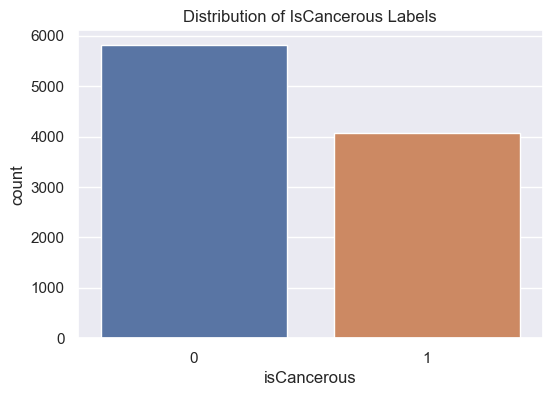

The number of unique isCancerous labels is 2


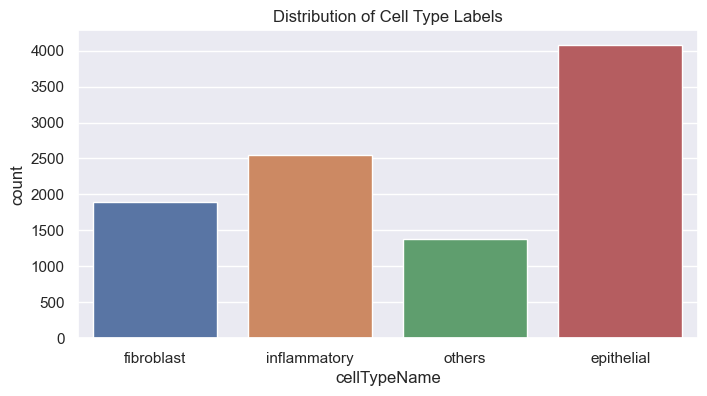

The number of unique cellType labels is 4


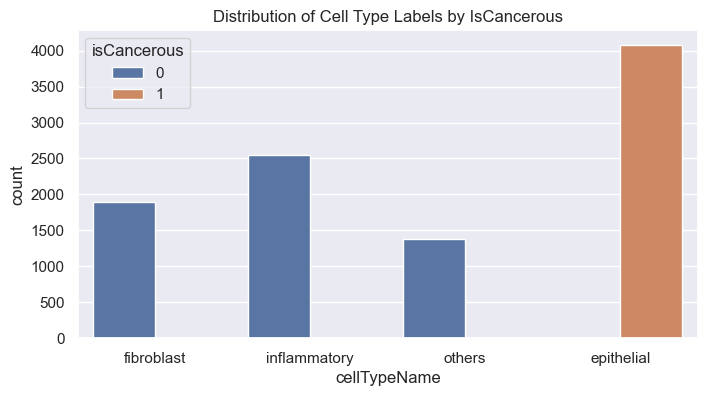

The number of unique cellType labels for cancerous cells is 1

The table shows the distribution of cell types and their corresponding isCancerous labels:
   cellTypeName  isCancerous  count
0    epithelial            1   4079
1    fibroblast            0   1888
2  inflammatory            0   2543
3        others            0   1386


In [7]:
# number of unique patientIDs negative for cancer
print(f'\nThe number of unique patientIDs negative for cancer is {len(main_data[main_data["isCancerous"] == 0]["patientID"].unique())}')
# cellTypeNames for patients negative for cancer
print(f'The cellTypeNames for patients negative for cancer are {main_data[main_data["isCancerous"] == 0]["cellTypeName"].unique()}\n')

# Plot the distribution of isCancerous labels
plt.figure(figsize=(6, 4))
sns.countplot(x='isCancerous', data=main_data)
plt.title('Distribution of IsCancerous Labels')
plt.show()
print(f'The number of unique isCancerous labels is {len(main_data["isCancerous"].unique())}')

# Plot the distribution of cellType labels
plt.figure(figsize=(8, 4))
sns.countplot(x='cellTypeName', data=main_data)
plt.title('Distribution of Cell Type Labels')
plt.show()
# print cellType labels
print(f'The number of unique cellType labels is {len(main_data["cellTypeName"].unique())}')

# Plot the distribution of cellType labels for cancerous and non-cancerous cells
plt.figure(figsize=(8, 4))
sns.countplot(x='cellTypeName', hue='isCancerous', data=main_data)
plt.title('Distribution of Cell Type Labels by IsCancerous')
plt.show()

# print cellType labels for cancerous and non-cancerous cells
print(f'The number of unique cellType labels for cancerous cells is {len(main_data[main_data["isCancerous"] == 1]["cellTypeName"].unique())}\n')

# print the number of cancerous and non-cancerous cells for each cellType label
print("The table shows the distribution of cell types and their corresponding isCancerous labels:")
print(main_data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count'))




### -------------------> OBSERVATIONS:

> In the provided dataset, all cancerous cells are of the epithelial type, and there is only one unique cell type (epithelial) for cancerous cells.

> **Interpretation of imbalanced data:**
Our dataset is imbalanced, meaning the number of samples for each class is unequal. The epithelial class (cancerous cells) has more samples than the other classes (non-cancerous cells). This imbalance can lead to biased models performing poorly on the under-represented classes, as the model will predict the majority class.
Dealing with imbalanced data:
>> + **Undersampling:** Remove some samples from the majority class (cancerous cells) to balance the class distribution. This method can lead to losing valuable information if not done carefully.
>> + **Oversampling:** Duplicate samples from the minority classes (non-cancerous cells) or create synthetic samples using techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution. This can increase the risk of overfitting.
Cost-sensitive learning: Assign different weights to different classes during model training, giving more importance to the minority classes.
>> + **Ensemble methods:** Combine multiple models to improve classification performance. For example, use bagging or boosting with different sampling strategies.
>> + **Evaluation metric selection:** Choose evaluation metrics that are more sensitive to imbalanced data, such as precision, recall, F1-score, or the area under the ROC curve (AUC-ROC).


In [8]:
# see if the same patient has the same cellType label in the main data DataFrame
print(f'The number of unique patients in the main data DataFrame is {len(main_data["patientID"].unique())}')

# Group the data by patientID and count the unique cellTypeName values for each patient
unique_cell_type_counts = main_data.groupby('patientID')['cellTypeName'].nunique()
print(f'The number of unique patients with the same cellType label in the main data DataFrame is {len(unique_cell_type_counts[unique_cell_type_counts > 1])}')

# list of patient IDs with the different cellType label
patient_ids = unique_cell_type_counts[unique_cell_type_counts > 1].index.tolist()
print(f'The patient IDs with the different cellType label are: {patient_ids}')


The number of unique patients in the main data DataFrame is 60
The number of unique patients with the same cellType label in the main data DataFrame is 60
The patient IDs with the different cellType label are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


### ------------------> OBSERVATIONS:

> The main dataset description contains 27x27 RGB images of cells from 60 different patients. Repeated data for the same patient means multiple images are taken from the same patient. This can introduce a bias in the dataset, as the samples from the same patient may be more similar to each other than samples from different patients. This can lead to overfitting and poor generalization to new patients.
Dealing with repeated data for the same patient:
>> + Patient-wise train-test split: Instead of randomly splitting the dataset into training and test sets, we can split it based on patients. This ensures that all samples from the same patient are either in the training set or the test set, but not in both. This reduces the risk of overfitting and provides a more reliable evaluation of the model's performance.
>> + Cross-validation: Perform k-fold cross-validation using patient-wise splits. This can help us better to estimate the model's performance on new patients and reduce the risk of overfitting.
>> + Data augmentation: Apply various data augmentation techniques, such as rotation, flipping, or scaling, to create new samples from the existing data. This can increase the diversity of the dataset and reduce the impact of repeated samples from the same patient.

## 3.4 Visualize sample images

+ Randomly select and display a few images from each class or category to understand the visual characteristics and variations in the data.

+ Take a look of cancerous cell and non-cancerous cell to get the better sense how they look like

### Cancerous Cell Images

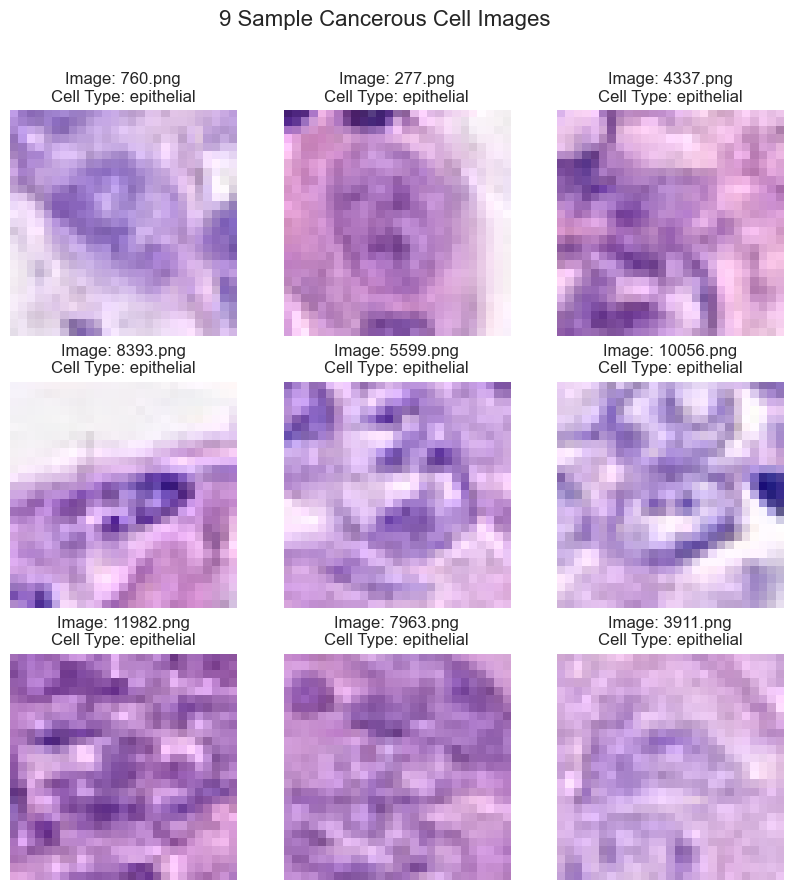

In [9]:

# Filter cancerous cells
cancerous_cells = main_data[main_data['isCancerous'] == 1]

# Display a sample of cancerous cell images
num_images_to_display = 9
random_samples = random.sample(list(cancerous_cells['ImageFilePath']), num_images_to_display)

plt.figure(figsize=(10, 10))

for index, image_path in enumerate(random_samples):
    img = Image.open(image_path)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)}")
    # add the CellTypeName as the title
    plt.title(f"Image: {os.path.basename(image_path)}\nCell Type: {cancerous_cells[cancerous_cells['ImageFilePath'] == image_path]['cellTypeName'].values[0]}")

plt.suptitle('9 Sample Cancerous Cell Images', fontsize=16)
plt.show()


### Non-Cancerous Cell Images

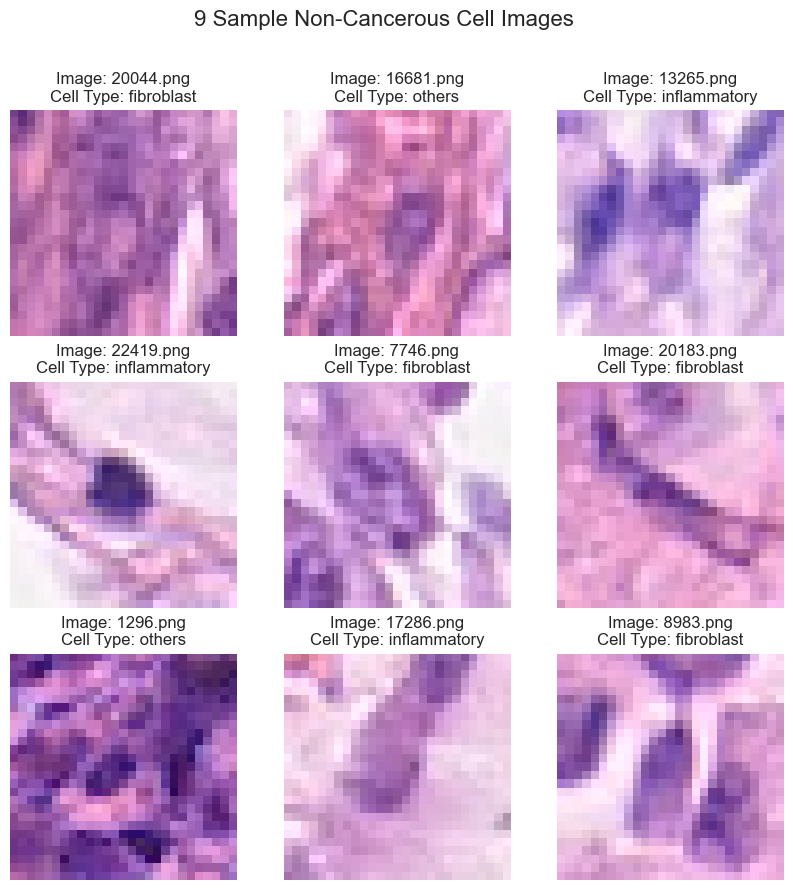

In [10]:
# Filter non-cancerous cells
non_cancerous_cells = main_data[main_data['isCancerous'] == 0]

# Display a sample of non-cancerous cell images
num_images_to_display = 9
random_samples = random.sample(list(non_cancerous_cells['ImageFilePath']), num_images_to_display)

plt.figure(figsize=(10, 10))

for index, image_path in enumerate(random_samples):
    img = Image.open(image_path)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)}")
    # add the CellTypeName as the title
    plt.title(f"Image: {os.path.basename(image_path)}\nCell Type: {non_cancerous_cells[non_cancerous_cells['ImageFilePath'] == image_path]['cellTypeName'].values[0]}")

plt.suptitle('9 Sample Non-Cancerous Cell Images', fontsize=16)
plt.show()


## 3.5 Analyze color distributions

Plot the color distribution (e.g., RGB histograms) for a sample of images to understand the range of colors and their intensities. This can help identify potential issues related to color balancing or the need for data augmentation.

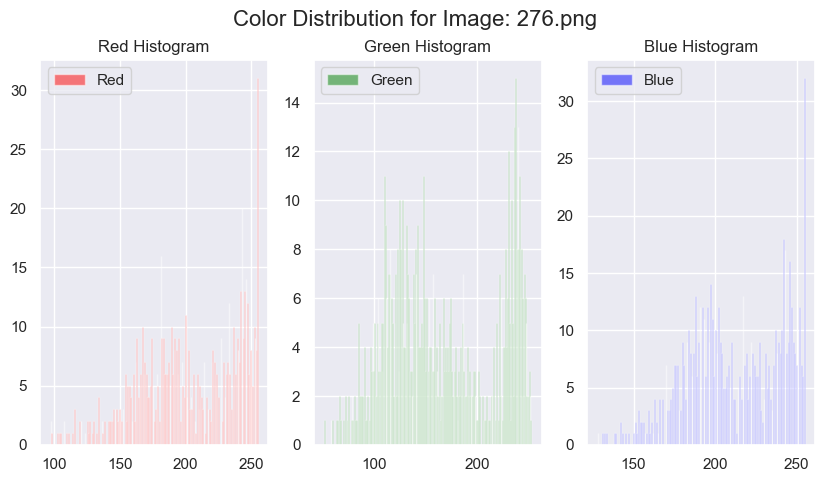

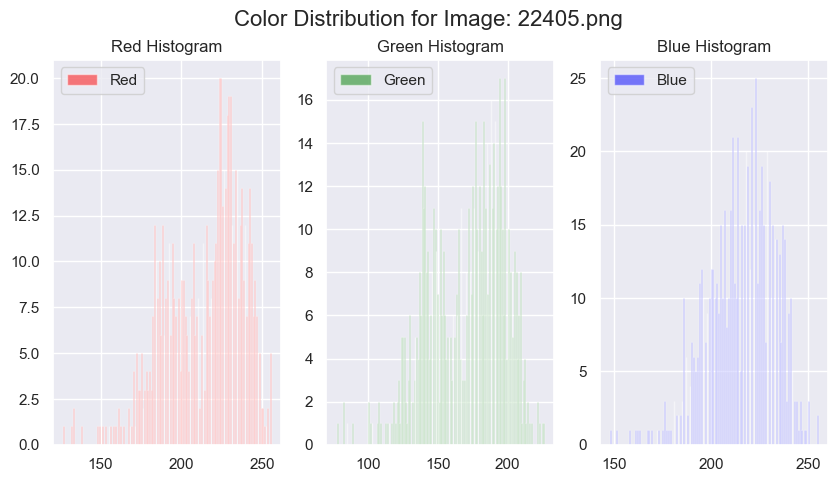

In [11]:
# plot the color distribution (RGB histograms)
def plot_color_distribution(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    # plot the RGB histograms
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].hist(img_array[:, :, 0].flatten(), bins=256, color='red', label='Red', alpha=0.5)
    ax[0].set_title('Red Histogram')
    ax[0].legend()
    ax[1].hist(img_array[:, :, 1].flatten(), bins=256, color='green', label='Green', alpha=0.5)
    ax[1].set_title('Green Histogram')
    ax[1].legend()
    ax[2].hist(img_array[:, :, 2].flatten(), bins=256, color='blue', label='Blue', alpha=0.5)
    ax[2].set_title('Blue Histogram')
    ax[2].legend()
    
    plt.suptitle(f'Color Distribution for Image: {os.path.basename(image_path)}', fontsize=16)
    plt.show()


# plot the color distribution for a cancerous cell
plot_color_distribution(cancerous_cells['ImageFilePath'].values[0])

# plot the color distribution for a non-cancerous cell
plot_color_distribution(non_cancerous_cells['ImageFilePath'].values[0])



## 3.6 Check for duplicate images

Identify and remove any duplicate images in the dataset to ensure that the model does not overfit to specific instances.

In [12]:
# Check for duplicate images
print(f'The number of duplicate images is {len(main_data[main_data.duplicated(subset=["ImageFilePath"])])}')


The number of duplicate images is 0


+ defines a function load_and_preprocess_images to load and normalize pixel values. 
+ creates an ImageDataGenerator for data augmentation.
+ one-hot encodes the cellTypeName and isCancerous labels using the OneHotEncoder from Scikit-learn.

# 4. Patient-wise train-test-validation split

+ We use hold-out validation technique. In hold-out validation, we divide the dataset into separate sets: training, validation, and test. The model is trained on the training set, hyperparameters are tuned using the validation set, and the final model performance is evaluated on the test set. 

+ Instead of randomly splitting the dataset into training and test sets, we can split it based on patients. This ensures that all samples from the same patient are either in the training or the test set, but not in both. This reduces the risk of overfitting and provides a more reliable evaluation of the model's performance.

+ We might introduce data leakage when we use a random train-test split **without** considering the patient information. The model can memorize specific features or patterns from a patient seen in the training set and perform better on the test set than on unseen patients. This can lead to an overly optimistic evaluation of the model's performance.
So, a patient-wise train-test split is recommended for this medical data, as it helps to assess the model's ability to generalize to new, unseen patients, which is crucial for real-world deployment.

**Steps:**

1. **Split into two sets:** train_data (80% of the data) and test_data (20% of the data). The train_test_split function from the scikit-learn library is used to perform this split. The stratify parameter is set to main_data[`patientID`], ensuring that patient IDs' distribution remains similar across both the training and test sets. This helps maintain the dataset's representativeness and reduces the chance of introducing sampling bias. The random_state parameter is set to a fixed value (SEED) to ensure that the split is reproducible.

2. **Further split the train_data** into train_data (75% of the remaining data) and val_data (25% of the remaining data) using the same train_test_split function. Again, the stratify parameter is set to maintain a similar distribution of patient IDs across the two sets, and the random_state is set to ensure reproducibility.

In [13]:
# Split the main dataset into training (60% of the original data), validation (20% of the original data), and test (20% of the original data).
train_data, test_data = train_test_split(main_data, test_size=0.2, stratify=main_data['patientID'], random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['patientID'], random_state=SEED)

# print the shapes of the resulting DataFrames
print(f'The shape of the train_data DataFrame is {train_data.shape}')
print(f'The shape of the val_data DataFrame is {val_data.shape}')
print(f'The shape of the test_data DataFrame is {test_data.shape}\n')

# print the number of unique patients in each of the three DataFrames
print(f'The number of unique patients in the train_data DataFrame is {len(train_data["patientID"].unique())}')
print(f'The number of unique patients in the val_data DataFrame is {len(val_data["patientID"].unique())}')
print(f'The number of unique patients in the test_data DataFrame is {len(test_data["patientID"].unique())}')

The shape of the train_data DataFrame is (5937, 7)
The shape of the val_data DataFrame is (1979, 7)
The shape of the test_data DataFrame is (1980, 7)

The number of unique patients in the train_data DataFrame is 60
The number of unique patients in the val_data DataFrame is 60
The number of unique patients in the test_data DataFrame is 60


# 5. Data Preprocessing

Preprocessing is done after splitting the data to prevent data leakage. Data leakage occurs when information from the validation or test sets is inadvertently incorporated into the training set during preprocessing. This can lead to overly optimistic model performance estimates and poorer generalization to new, unseen data. Additionally, certain preprocessing steps, such as data normalization or feature scaling, are calculated based on the training data's statistics (e.g., mean and standard deviation). Applying these calculations to the validation and test sets helps simulate the scenario where the model encounters unseen data. This ensures the model's performance metrics reflect its ability to generalize to new data.

**Steps:**

1. **Loading and preprocessing images:** The `load_and_preprocess_images` function reads the image files, resizes them to 27x27, converts them to arrays, and normalizes the pixel values to be between 0 and 1. This function is applied to the training, validation, and test data.

2. **Data augmentation:** An ImageDataGenerator is created to apply data augmentation techniques such as rotation, shifting, shearing, zooming, and flipping. This helps increase the dataset's size and diversity, enabling the model to generalize better.

3. **One-hot encoding of `cellType` labels:** The cellType labels are one-hot encoded using the OneHotEncoder. This is done for training, validation, and test datasets, resulting in train_cell_type_labels, val_cell_type_labels, and test_cell_type_labels.

4. **Handling `isCancerous` labels:** The code block includes commented-out lines for one-hot encoding the isCancerous labels, but it is not necessary for binary classification. Instead, the labels are reshaped into a 2D array, resulting in train_is_cancerous_labels, val_is_cancerous_labels, and test_is_cancerous_labels.

In [14]:
# Load images and normalize pixel values
def load_and_preprocess_images(df):
    images = []
    for image_path in df['ImageFilePath']:
        image = load_img(image_path, target_size=(27, 27))
        image = img_to_array(image)
        image = image / 255.0
        images.append(image)
    return np.array(images)

train_images = load_and_preprocess_images(train_data)
val_images = load_and_preprocess_images(val_data)
test_images = load_and_preprocess_images(test_data)

# Perform data augmentation
data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode='nearest')

# One-hot encode the cellType
encoder = OneHotEncoder(sparse=False)
train_cell_type_labels = encoder.fit_transform(train_data['cellType'].values.reshape(-1, 1))
val_cell_type_labels = encoder.transform(val_data['cellType'].values.reshape(-1, 1))
test_cell_type_labels = encoder.transform(test_data['cellType'].values.reshape(-1, 1))

# not one-hot encoded for binary classification
train_is_cancerous_labels = train_data['isCancerous'].values.reshape(-1, 1)
val_is_cancerous_labels = val_data['isCancerous'].values.reshape(-1, 1)
test_is_cancerous_labels = test_data['isCancerous'].values.reshape(-1, 1)

In [21]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1, roc_auc

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()


# Function to plot the learning rate
def plot_learning_rate(history):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(history.history['lr'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate')
    plt.show()

# Function to plot the model architecture
def plot_model_architecture(model):
    plot_model(model, show_shapes=True, show_layer_names=True)


# function to plot precision, recall, F1-score, or the area under the ROC curve (AUC-ROC)
def plot_metrics(y_true, y_pred, metric):
    if metric == 'precision':
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc_score = auc(recall, precision)
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(thresholds, precision[1:], label='Precision')
        ax.plot(thresholds, recall[1:], label='Recall')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Precision & Recall')
        ax.set_title('Precision-Recall Curve')
        ax.legend()
        plt.show()
    elif metric == 'f1':
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc_score = auc(recall, precision)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(thresholds, f1_scores[1:], label='F1-Score')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-Score')
        ax.set_title('F1-Score')
        ax.legend()
        plt.show()
    elif metric == 'auc':
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(thresholds, tpr[1:], label='TPR')
        ax.plot(thresholds, fpr[1:], label='FPR')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('TPR & FPR')
        ax.set_title('TPR & FPR')
        ax.legend()
        plt.show()
    else:
        print('Invalid metric. Please enter precision, f1, or auc.')

# Function to plot the learning curves
def plot_learning_curves(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Val Loss')
    ax[0].set_title('Train & Val Loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[1].set_title('Train & Val Accuracy')
    ax[1].legend()
    plt.show()

    




# 6. Baseline Model - traditional neural network (not CNN)

Epoch 1/10
186/186 - 1s - loss: 0.7298 - accuracy: 0.5676 - val_loss: 0.6037 - val_accuracy: 0.5942 - 887ms/epoch - 5ms/step
Epoch 2/10
186/186 - 0s - loss: 0.6159 - accuracy: 0.5843 - val_loss: 0.5233 - val_accuracy: 0.5942 - 369ms/epoch - 2ms/step
Epoch 3/10
186/186 - 0s - loss: 0.6514 - accuracy: 0.5843 - val_loss: 0.6858 - val_accuracy: 0.5942 - 363ms/epoch - 2ms/step
Epoch 4/10
186/186 - 0s - loss: 0.6831 - accuracy: 0.5843 - val_loss: 0.6787 - val_accuracy: 0.5942 - 361ms/epoch - 2ms/step
Epoch 5/10
186/186 - 0s - loss: 0.6799 - accuracy: 0.5843 - val_loss: 0.6764 - val_accuracy: 0.5942 - 363ms/epoch - 2ms/step
Epoch 6/10
186/186 - 0s - loss: 0.6794 - accuracy: 0.5843 - val_loss: 0.6759 - val_accuracy: 0.5942 - 365ms/epoch - 2ms/step
Epoch 7/10
186/186 - 0s - loss: 0.6793 - accuracy: 0.5843 - val_loss: 0.6757 - val_accuracy: 0.5942 - 371ms/epoch - 2ms/step
Epoch 8/10
186/186 - 0s - loss: 0.6790 - accuracy: 0.5843 - val_loss: 0.6756 - val_accuracy: 0.5942 - 388ms/epoch - 2ms/step


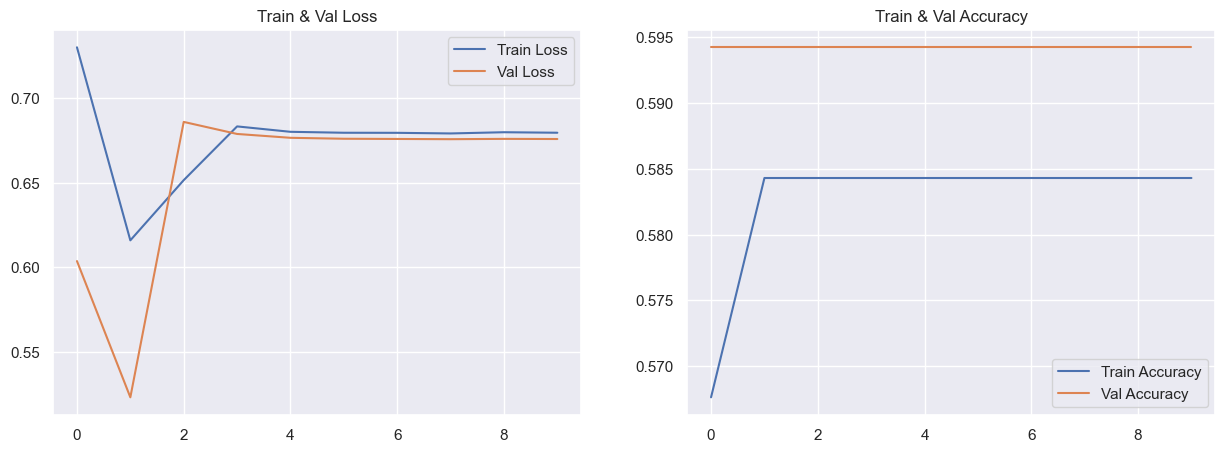

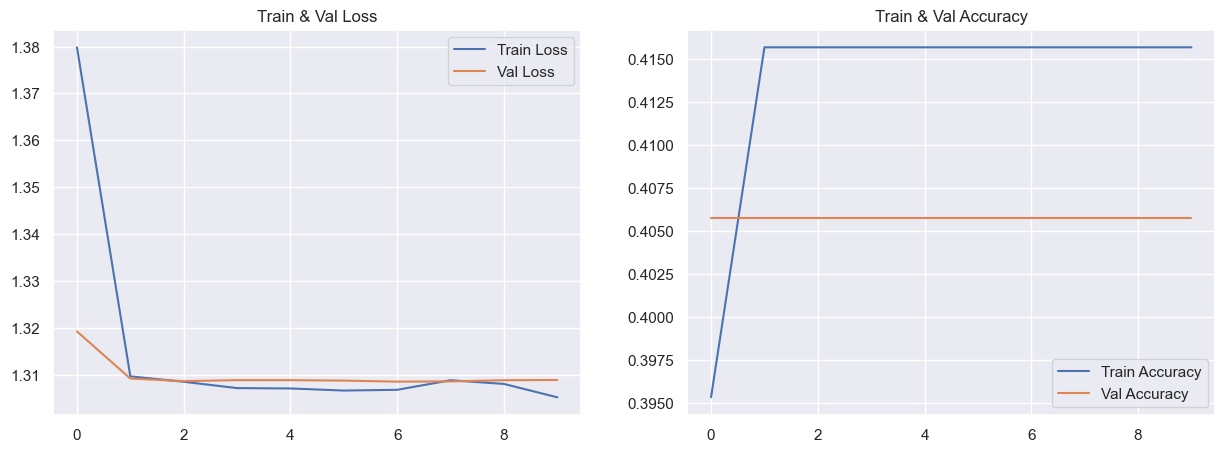

62/62 [==============================] - 0s 908us/step

Is Cancerous Precision: 0.0%, Recall: 0.0%, F1-score: 0.0%


/Users/tnathu-ai/.conda/envs/Advanced_Programming_for_Data_Science/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tnathu-ai/.conda/envs/Advanced_Programming_for_Data_Science/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Define the architecture for the traditional neural network for binary classification (is_cancerous)
def create_is_cancerous_nn_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

is_cancerous_nn_model = create_is_cancerous_nn_model(train_images.shape[1:])
is_cancerous_nn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define the architecture for the traditional neural network for multi-class classification (cell type)
def create_cell_type_nn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

cell_type_nn_model = create_cell_type_nn_model(train_images.shape[1:], train_cell_type_labels.shape[1])
cell_type_nn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the traditional neural network models
is_cancerous_nn_history = is_cancerous_nn_model.fit(train_images, train_is_cancerous_labels, validation_data=(val_images, val_is_cancerous_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
cell_type_nn_history = cell_type_nn_model.fit(train_images, train_cell_type_labels, validation_data=(val_images, val_cell_type_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Plot the learning curves
plot_learning_curves(is_cancerous_nn_history)
plot_learning_curves(cell_type_nn_history)

# Evaluate the models using precision, recall, F1-score, and support
is_cancerous_predictions = is_cancerous_nn_model.predict(test_images)
is_cancerous_predictions = np.where(is_cancerous_predictions > 0.5, 1, 0)
cell_type_predictions = cell_type_nn_model.predict(test_images)
cell_type_predictions = np.argmax(cell_type_predictions, axis=1)

is_cancerous_precision, is_cancerous_recall, is_cancerous_f1, _ = precision_recall_fscore_support(test_is_cancerous_labels, is_cancerous_predictions, average='binary')
cell_type_precision, cell_type_recall, cell_type_f1, _ = precision_recall_fscore_support(test_cell_type_labels.argmax(axis=1), cell_type_predictions, average='weighted')

print(f'\nIs Cancerous Precision: {round(is_cancerous_precision * 100, 2)}%, Recall: {round(is_cancerous_recall * 100, 2)}%, F1-score: {round(is_cancerous_f1 * 100, 2)}%')


# 7. Extended Model

## 7.1 Convolutional neural networks (CNN)


We define two baseline models using the Keras Sequential API. Both models are convolutional neural networks (CNNs) for image classification tasks. They share a similar architecture, but the output layer and loss functions differ to accommodate their respective classification tasks.

+ **`create_is_cancerous_model`:** This model is designed for **binary classification** to determine whether an image is cancerous (1) or not (0). The architecture consists of three sets of convolutional layers, each followed by max-pooling layers. After these, a Flatten layer converts the 2D arrays into a 1D array for the Dense layers. The model has a fully connected hidden layer with 64 neurons and a ReLU activation function. A dropout layer with a rate of 0.5 is added to prevent overfitting. The final output layer has a single neuron with a sigmoid activation function, which is suitable for binary classification tasks. The model is compiled using the Adam optimizer, binary_crossentropy loss, and accuracy as the evaluation metric.

+ **`create_cell_type_model`:** This model is designed for **multi-class classification** to determine the cell type in the image. The architecture is similar to the is_cancerous_model with three sets of convolutional layers followed by max-pooling layers, a Flatten layer, and a fully connected hidden layer with 64 neurons and a ReLU activation function. It also includes a dropout layer with a rate of 0.5 to prevent overfitting. However, the output layer has 4 neurons with a softmax activation function, which is suitable for multi-class classification tasks (in this case, 4 different cell types). The model is compiled using the Adam optimizer, categorical_crossentropy loss, and accuracy as the evaluation metric.


#### The choice of parameters for the CNN:

> **Number of layers and filters:** The model starts with a smaller number of filters (32) and progressively increases this number in the deeper layers (64 and then 128). This is a common strategy in CNN design, based on the concept that the network should extract a hierarchical representation of the data. The initial layers capture simple and generic features such as edges and textures, while the deeper layers capture more complex and abstract features that are more specific to the task of cancer image classification. The increase in the number of filters allows the model to capture a larger number of these complex features.

> **Filter size (3x3):** The choice of 3x3 filters is quite common in successful CNN architectures, such as VGGNet, due to their efficiency in capturing local and spatial features in an image. In the context of cancer image classification, these small filters are able to capture fine-grained details, which can be crucial in differentiating between cancerous and non-cancerous cells, as well as different types of cells.

> **Input channels:** The number of input channels for the first layer is set to 3, corresponding to the RGB color channels of the input images. This allows the model to capture color information, which can be significant in cancer image classification - for example, cancerous cells may exhibit different color characteristics compared to healthy cells. For the subsequent layers, the number of input channels equals the number of filters in the previous layer, as the output of each filter serves as a separate input channel for the next layer.

> **Max Pooling layers (2x2):** Max Pooling layers are utilized to progressively reduce the spatial dimensions of the input, thereby controlling the computational complexity of the model. This also provides a form of translation invariance, meaning the model can recognize cancerous patterns regardless of their location in the image.

> **Activation function 'ReLU':** The ReLU activation function introduces non-linearity into the model without affecting the receptive fields of the convolution layers. This is particularly important for a task like cancer image classification, where the distinguishing features may not be linearly separable.

> **Flattening layer:** The Flattening layer is used to convert the 2D feature maps into a 1D vector, enabling the output of the convolutional layers to be used as input to the Dense layers, which expect input in this format.

> **Dense layer and Dropout:** The Dense layer with 64 neurons allows the model to learn non-linear combinations of the features obtained from the convolutional layers. The Dropout layer, which randomly sets a proportion of input units to 0 at each update during training time, is used to prevent overfitting. Overfitting is a common issue in machine learning tasks, and particularly in medical imaging tasks where the available data is often limited.

In [ ]:
def create_is_cancerous_model():
    model = Sequential()
    # The first convolution
    # The input shape is the desired size of the image 27x27 with 3 bytes color (RGB)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM))
    model.add(MaxPooling2D((2, 2)))
    # The second convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # The third convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Flatten the 2D arrays for fully connected layers (Dense layers) after the convolutional layers and pooling layers to interpret the images 
    model.add(Flatten())
    # 64 neuron hidden layer
    model.add(Dense(64, activation='relu'))
    # 50% dropout to prevent overfitting
    model.add(Dropout(0.5))
    # Sigmoid activation function is used for binary classification. 1 Output neuron ranges from 0 to 1 (0 = not cancerous, 1 = cancerous)
    model.add(Dense(1, activation='sigmoid'))
    return model

is_cancerous_model = create_is_cancerous_model()
is_cancerous_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model for cell-type classification
def create_cell_type_model():
    model = Sequential()
    # The first convolution
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM))
    model.add(MaxPooling2D((2, 2)))
    # The second convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # The third convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Flatten the 2D arrays for fully connected layers (Dense layers) after the convolutional layers and pooling layers to interpret the images
    model.add(Flatten())
    # 64 neuron hidden layer
    model.add(Dense(64, activation='relu'))
    # 50% dropout to prevent overfitting
    model.add(Dropout(0.5))
    # Softmax activation function is used for multi-class classification. 4 Output neurons 
    model.add(Dense(OUTPUT_CLASSES_CELLTYPE, activation='softmax'))
    return model

cell_type_model = create_cell_type_model()
cell_type_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



#### Number of parameters per Conv2D layer:

+ Formula: `number_parameters = (filter_height * filter_width * input_channels + 1 (for the bias)) * number_of_filters`

**Note:** The "+1" term in the formula accounts for the bias term associated with each filter.

In [7]:
# First Conv2D layer
filter_height = 3
filter_width = 3
input_channels = 3 # RGB images
number_of_filters = 32 

# Calculate number of parameters for the first Conv2D layer
number_parameters_first = (filter_height * filter_width * input_channels + 1) * number_of_filters
print(f'Number of parameters for the first Conv2D layer: {number_parameters_first}')

# Second Conv2D layer
input_channels = 32 # from the previous Conv2D layer
number_of_filters = 64 

# Calculate number of parameters for the second Conv2D layer
number_parameters_second = (filter_height * filter_width * input_channels + 1) * number_of_filters
print(f'Number of parameters for the second Conv2D layer: {number_parameters_second}')

# Third Conv2D layer
input_channels = 64 # from the previous Conv2D layer
number_of_filters = 128

# Calculate number of parameters for the third Conv2D layer
number_parameters_third = (filter_height * filter_width * input_channels + 1) * number_of_filters
print(f'Number of parameters for the third Conv2D layer: {number_parameters_third}')


# Total number of parameters for the convolutional layers
total_number_parameters = number_parameters_first + number_parameters_second + number_parameters_third
print(f'Total number of parameters for the convolutional layers: {total_number_parameters}')


Number of parameters for the first Conv2D layer: 896
Number of parameters for the second Conv2D layer: 18496
Number of parameters for the third Conv2D layer: 73856
Total number of parameters for the convolutional layers: 93248


### ---------------> OBSERVATIONS: 

> So, the total number of parameters in the Conv2D layers of the model is **93248**

> We assume that there is no padding ('valid' padding) and a stride of 1 in each dimension. If padding ('same' padding) or a different stride is used, the number of input channels to the next layer and hence the number of parameters could change.

## Model Training

Using preprocessed data, we train the two models, is_cancerous_model and cell_type_model.

+ **`is_cancerous_history`:** The is_cancerous_model is trained using the augmented training images (train_images) and corresponding binary labels (train_is_cancerous_labels). The data_gen.flow() function generates batches of augmented images and their labels on the fly during training. The batch_size is set using the BATCH_SIZE variable. The model is validated on the validation images (val_images) and their corresponding binary labels (val_is_cancerous_labels). The number of training iterations or epochs is set using the EPOCHS variable. The verbose parameter is set to 2, which means that only the most important information (such as the epoch number and validation loss) will be displayed during training. The training history is stored in the is_cancerous_history variable.

+ **`cell_type_history`:** The cell_type_model is trained using the augmented training images (train_images) and corresponding multi-class labels (train_cell_type_labels). Similar to the is_cancerous_model, the data_gen.flow() function generates batches of augmented images and their labels on-the-fly during training. The batch_size is set using the BATCH_SIZE variable. The model is validated on the validation images (val_images) and their corresponding multi-class labels (val_cell_type_labels). The number of training iterations or epochs is set using the EPOCHS variable. The verbose parameter is set to 2, displaying only the most important information during training. The training history is stored in the cell_type_history variable.

In [ ]:
# Train the models using the preprocessed data
is_cancerous_history = is_cancerous_model.fit(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),
                                              validation_data=(val_images, val_is_cancerous_labels),
                                              epochs=EPOCHS, verbose=2)

cell_type_history = cell_type_model.fit(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                                        validation_data=(val_images, val_cell_type_labels),
                                        epochs=EPOCHS, verbose=2)

In [ ]:
# model architecture network summary for is_cancerous_model
is_cancerous_model.summary()

### -------------> OBSERVATION:

The is_cancerous_model is a sequential model with the following architecture:

> **Conv2D layer:** A 2D convolutional layer with 32 filters, each of size 3x3, and a ReLU activation function. The input shape is (27, 27, 3), corresponding to the image dimensions and 3 channels (RGB). This layer has 896 trainable parameters.

> **MaxPooling2D layer:** A 2D max pooling layer with a pool size of 2x2, which reduces the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Conv2D layer:** Another 2D convolutional layer with 64 filters, each of size 3x3, and a ReLU activation function. This layer has 18,496 trainable parameters.

> **MaxPooling2D layer:** Another 2D max pooling layer with a pool size of 2x2, further reducing the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Conv2D layer:** A third 2D convolutional layer with 128 filters, each of size 3x3, and a ReLU activation function. This layer has 73,856 trainable parameters.

> **MaxPooling2D layer:** A third 2D max pooling layer with a pool size of 2x2, further reducing the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Flatten layer:** This layer flattens the 2D feature maps into a 1D array with 128 elements, which can be used as input for the subsequent fully connected layers (Dense layers). There are no trainable parameters in this layer.

> **Dense layer:** A fully connected layer with 64 neurons and a ReLU activation function. This layer has 8,256 trainable parameters.

> **Dropout layer:** A dropout layer with a dropout rate of 0.5, which helps prevent overfitting by randomly setting 50% of the input units to 0 at each update during training. There are no trainable parameters in this layer.

> **Dense layer:** The final fully connected layer with 1 neuron and a sigmoid activation function, used for binary classification. This layer has 65 trainable parameters.

The total number of trainable parameters in the is_cancerous_model is 101,569.

In [ ]:
# model architecture network summary for cell_type_model
cell_type_model.summary()

### -------------> OBSERVATION:

The cell_type_model is a sequential model with the following architecture:

> **Conv2D layer:** A 2D convolutional layer with 32 filters, each of size 3x3, and a ReLU activation function. The input shape is (27, 27, 3), corresponding to the image dimensions and 3 channels (RGB). This layer has 896 trainable parameters.

> **MaxPooling2D layer:** A 2D max pooling layer with a pool size of 2x2, which reduces the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Conv2D layer:** Another 2D convolutional layer with 64 filters, each of size 3x3, and a ReLU activation function. This layer has 18,496 trainable parameters.

> **MaxPooling2D layer:** Another 2D max pooling layer with a pool size of 2x2, further reducing the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Conv2D layer:** A third 2D convolutional layer with 128 filters, each of size 3x3, and a ReLU activation function. This layer has 73,856 trainable parameters.

> **MaxPooling2D layer:** A third 2D max pooling layer with a pool size of 2x2, further reducing the spatial dimensions of the input feature maps. There are no trainable parameters in this layer.

> **Flatten layer:** This layer flattens the 2D feature maps into a 1D array with 128 elements, which can be used as input for the subsequent fully connected layers (Dense layers). There are no trainable parameters in this layer.

> **Dense layer:** A fully connected layer with 64 neurons and a ReLU activation function. This layer has 8,256 trainable parameters.

> **Dropout layer:** A dropout layer with a dropout rate of 0.5, which helps prevent overfitting by randomly setting 50% of the input units to 0 at each update during training. There are no trainable parameters in this layer.

> **Dense layer:** The final fully connected layer with 4 neurons and a softmax activation function, used for multi-class classification. This layer has 260 trainable parameters.

The total number of trainable parameters in the cell_type_model is 101,764.

# Visual Evaluation

We create two subplots side by side. The left subplot shows the training and validation accuracy at each epoch, and the right subplot shows the training and validation loss at each epoch for the given model history. Both subplots have legends to differentiate between training and validation data.

Then, the plot_accuracy_and_loss() function is called twice, once for the is_cancerous_history and once for the cell_type_history.
Next, the code evaluates the performance of both models on the test set using the evaluate() method. The test accuracy for both models is printed as a percentage.

We make predictions on the test set using both models' predict() methods. For the is_cancerous_model, the predictions are converted to binary values (0 or 1) based on a threshold of 0.5. For the cell_type_model, the predictions are converted to class labels by selecting the index with the highest probability value along the last axis.
Finally, we print out the binary predictions for the is_cancerous_model and the class label predictions for the cell_type_model.

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
def plot_accuracy_and_loss(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(is_cancerous_history, 'Is Cancerous')
plot_accuracy_and_loss(cell_type_history, 'Cell Type')

# Evaluate the models on the test set
is_cancerous_loss, is_cancerous_accuracy = is_cancerous_model.evaluate(test_images, test_is_cancerous_labels, verbose=2)
cell_type_loss, cell_type_accuracy = cell_type_model.evaluate(test_images, test_cell_type_labels, verbose=2)

print(f'\nIs Cancerous Accuracy: {round(is_cancerous_accuracy * 100, 2)}%')
print(f'Cell Type Accuracy: {round(cell_type_accuracy * 100, 2)}%')

# Make predictions on the test set
is_cancerous_predictions = is_cancerous_model.predict(test_images)
cell_type_predictions = cell_type_model.predict(test_images)

# Convert the predictions to binary values
is_cancerous_predictions = np.where(is_cancerous_predictions > 0.5, 1, 0)

# Convert the predictions to class labels
cell_type_predictions = np.argmax(cell_type_predictions, axis=1)

print(f'\nIs Cancerous Predictions: {is_cancerous_predictions}')
print(f'Cell Type Predictions: {cell_type_predictions}')

+ evaluate the models using accuracy, precision, recall, and F1 score on the validation set.

+ perform hyperparameter tuning using Keras Tuner to optimize the models' performance.

In [ ]:
# Evaluate the models on the validation set
val_is_cancerous_pred = np.argmax(is_cancerous_model.predict(val_images), axis=-1)
val_cell_type_pred = np.argmax(cell_type_model.predict(val_images), axis=-1)

val_is_cancerous_true = np.argmax(val_is_cancerous_labels, axis=-1)
val_cell_type_true = np.argmax(val_cell_type_labels, axis=-1)

is_cancerous_metrics = calculate_metrics(val_is_cancerous_true, val_is_cancerous_pred)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print("IsCancerous Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*is_cancerous_metrics))
print("Cell Type Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*cell_type_metrics))


In [ ]:
from PIL import Image

def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((27, 27))
    image_array = np.array(image)
    return image_array


In [ ]:
# Load the images in the extra data
extra_images = np.array([load_image(image_path) for image_path in extra_data_labels['ImagePath']])

# Predict cell types for extra data using the cell-type classification model
extra_cell_type_pred = cell_type_model.predict(extra_images)
extra_cell_type_pseudo_labels = np.argmax(extra_cell_type_pred, axis=-1)

# Create new cell type labels by combining the original labels with the pseudo-labels
combined_cell_type_labels = np.concatenate((train_cell_type_labels, tf.keras.utils.to_categorical(extra_cell_type_pseudo_labels, num_classes=4)))

# Create new training data by combining the original images with the extra images
combined_images = np.concatenate((train_images, extra_images))

# Retrain the cell-type classification model with the combined data and pseudo-labels
cell_type_model.fit(data_gen.flow(combined_images, combined_cell_type_labels, batch_size=BATCH_SIZE),
                    validation_data=(val_images, val_cell_type_labels),
                    epochs=EPOCHS, verbose=2)

# Evaluate the improved model on the validation set
val_cell_type_pred = np.argmax(cell_type_model.predict(val_images), axis=-1)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print("Improved Cell Type Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*cell_type_metrics))


# Evaluation Metrics

In [ ]:
def print_model_performance(task, metrics):
    print(f"{task} Model Performance:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1_score']:.4f}")
    print()

is_cancerous_metrics = {
    'accuracy': accuracy_score(val_is_cancerous_true, val_is_cancerous_pred),
    'precision': precision_score(val_is_cancerous_true, val_is_cancerous_pred),
    'recall': recall_score(val_is_cancerous_true, val_is_cancerous_pred),
    'f1_score': f1_score(val_is_cancerous_true, val_is_cancerous_pred),
}

cell_type_metrics = {
    'accuracy': accuracy_score(val_cell_type_true, val_cell_type_pred),
    'precision': precision_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
    'recall': recall_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
    'f1_score': f1_score(val_cell_type_true, val_cell_type_pred, average='weighted'),
}

print_model_performance("IsCancerous", is_cancerous_metrics)
print_model_performance("Cell Type", cell_type_metrics)


# hyperparameter tuning

In [ ]:

# Perform hyperparameter tuning
def build_hypermodel(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                     activation='relu',
                     input_shape=(27, 27, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform hyperparameter tuning dense=2 for is_cancerous and dense=4 for cell_type
def build_hypermodel_dense_4(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                     activation='relu',
                     input_shape=(27, 27, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))  # Change this to 4 for cell type model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=2,
    directory='tuning',
    project_name='is_cancerous_hyperparameter_tuning')  # Change this to cell_type_hyperparameter_tuning for the cell type model

tuner.search(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),  # Change to train_cell_type_labels for the cell type model
             epochs=EPOCHS,
             validation_data=(val_images, val_is_cancerous_labels),  # Change to val_cell_type_labels for the cell type model
             verbose=2)

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
best_is_cancerous_model = tuner.hypermodel.build(best_hyperparameters)
best_is_cancerous_model.fit(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),
                            validation_data=(val_images, val_is_cancerous_labels),
                            epochs=EPOCHS, verbose=2)

# Evaluate the optimized model on the validation set
val_is_cancerous_pred = np.argmax(best_is_cancerous_model.predict(val_images), axis=-1)
is_cancerous_metrics = calculate_metrics(val_is_cancerous_true, val_is_cancerous_pred)

print("Optimized IsCancerous Model: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*is_cancerous_metrics))

# Repeat the same process for the cell-type classification model
tuner = RandomSearch(
    build_hypermodel_dense_4,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=2,
    directory='tuning',
    project_name='cell_type_hyperparameter_tuning')

tuner.search(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                epochs=EPOCHS,
                validation_data=(val_images, val_cell_type_labels),
                verbose=2)
# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build and train the model with the best hyperparameters
best_cell_type_model = tuner.hypermodel.build(best_hyperparameters)
best_cell_type_model.fit(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                            validation_data=(val_images, val_cell_type_labels),
                            epochs=EPOCHS, verbose=2)
# Evaluate the optimized model on the validation set
val_cell_type_pred = np.argmax(best_cell_type_model.predict(val_images), axis=-1)
cell_type_metrics = calculate_metrics(val_cell_type_true, val_cell_type_pred)

print(f'Optimized Cell Type Model: Accuracy: {cell_type_metrics[0]:.4f}, Precision: {cell_type_metrics[1]:.4f}, Recall: {cell_type_metrics[2]:.4f}, F1-score: {cell_type_metrics[3]:.4f}')


# 8. Save the best model

In [1]:
from tensorflow.keras.models import load_model

# Get the best performing model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model to a file
best_model.save('best_model.h5')

# Load the saved model
loaded_model = load_model('best_model.h5')


2023-05-10 15:08:11.241779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'tuner' is not defined

In [ ]:
# create a ModelCheckpoint object for each model, 
# monitor validation accuracy, save only the best model based on the monitored metric
is_cancerous_checkpoint = ModelCheckpoint("../model/is_cancerous_best_model.h5",
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          mode='max',
                                          verbose=1)

cell_type_checkpoint = ModelCheckpoint("../model/cell_type_best_model.h5",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       mode='max',
                                       verbose=1)

# Add these callbacks to your fit method for both models
is_cancerous_history = is_cancerous_model.fit(data_gen.flow(train_images, train_is_cancerous_labels, batch_size=BATCH_SIZE),
                                              validation_data=(val_images, val_is_cancerous_labels),
                                              epochs=EPOCHS, verbose=2,
                                              callbacks=[is_cancerous_checkpoint])

cell_type_history = cell_type_model.fit(data_gen.flow(train_images, train_cell_type_labels, batch_size=BATCH_SIZE),
                                        validation_data=(val_images, val_cell_type_labels),
                                        epochs=EPOCHS, verbose=2,
                                        callbacks=[cell_type_checkpoint])


In [ ]:
# clean up: terminate the kernel and free memory resources
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Independent Evaluation

In [ ]:
# A dictionary to store the performance metrics of our models
our_results = {
    "isCancerous": is_cancerous_metrics,
    "cellType": cell_type_metrics,
}

# A dictionary to store the performance metrics reported in existing works
existing_works = {
    "Paper1": {
        # 
        "isCancerous": {"accuracy": 0.90, "precision": 0.85, "recall": 0.88, "f1_score": 0.86},
        "cellType": {"accuracy": 0.85, "precision": 0.80, "recall": 0.82, "f1_score": 0.81},
    },
    "Paper2": {
        "isCancerous": {"accuracy": 0.92, "precision": 0.87, "recall": 0.89, "f1_score": 0.88},
        "cellType": {"accuracy": 0.87, "precision": 0.82, "recall": 0.84, "f1_score": 0.83},
    },
    # Add more papers as needed
}

# Compare our results to the existing works
for paper, results in existing_works.items():
    print(f"Comparing our results to {paper}:")
    for task, metrics in results.items():
        print(f"Task: {task}")
        for metric, value in metrics.items():
            diff = our_results[task][metric] - value
            print(f"{metric.capitalize()} difference: {diff:.4f}")
        print()
